In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

# Extract Features from Wave Files

In [2]:
#directory to training data and json file
train_dir3='/home/aka/Documents/nsynth-train/audio/'
#directory to training data and json file
valid_dir3='/home/aka/Documents/nsynth-valid/audio/'
#directory to training data and json file
test_dir3='/home/aka/Documents/nsynth-test/audio/'

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [3]:
#read the raw json files as given in the training set
df_train_raw3 = pd.read_json(path_or_buf='nsynth-train/examples.json', orient='index')

In [4]:
#Get a count of instruments in ascending order
n_class_train3 = df_train_raw3['instrument_family'].value_counts(ascending=True)
n_class_train3

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [5]:
#Sample n files
df_train_sample3=df_train_raw3.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(1000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample3= df_train_sample3[df_train_sample3['instrument_family']!=9]

In [6]:
df_train_sample3.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_141-029-127,223293,16000,29,2,bass,bass_synthetic_141,bass_synthetic_141-029-127,[distortion],synthetic,127,0,949,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_014-039-025,256547,16000,39,2,bass,bass_synthetic_014,bass_synthetic_014-039-025,"[bright, distortion, fast_decay]",synthetic,25,0,220,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
bass_synthetic_006-059-025,209452,16000,59,2,bass,bass_synthetic_006,bass_synthetic_006-059-025,"[bright, distortion, multiphonic]",synthetic,25,0,68,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
bass_synthetic_123-085-050,198411,16000,85,2,bass,bass_synthetic_123,bass_synthetic_123-085-050,"[fast_decay, percussive]",synthetic,50,0,890,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
bass_synthetic_021-037-127,15945,16000,37,2,bass,bass_synthetic_021,bass_synthetic_021-037-127,[],synthetic,127,0,317,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [7]:
print(df_train_sample3.shape)

(10000, 13)


In [8]:
print(df_train_sample3["instrument_family_str"].unique())

['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'reed'
 'string' 'vocal']


In [9]:
df_train_sample3 = df_train_sample3[df_train_sample3["instrument_family_str"] != 'reed']
print(df_train_sample3["instrument_family_str"].unique())
df_train_sample3.head()

['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'string'
 'vocal']


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_141-029-127,223293,16000,29,2,bass,bass_synthetic_141,bass_synthetic_141-029-127,[distortion],synthetic,127,0,949,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_014-039-025,256547,16000,39,2,bass,bass_synthetic_014,bass_synthetic_014-039-025,"[bright, distortion, fast_decay]",synthetic,25,0,220,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0]"
bass_synthetic_006-059-025,209452,16000,59,2,bass,bass_synthetic_006,bass_synthetic_006-059-025,"[bright, distortion, multiphonic]",synthetic,25,0,68,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0]"
bass_synthetic_123-085-050,198411,16000,85,2,bass,bass_synthetic_123,bass_synthetic_123-085-050,"[fast_decay, percussive]",synthetic,50,0,890,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
bass_synthetic_021-037-127,15945,16000,37,2,bass,bass_synthetic_021,bass_synthetic_021-037-127,[],synthetic,127,0,317,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [10]:
df_train_sample3.shape

(9000, 13)

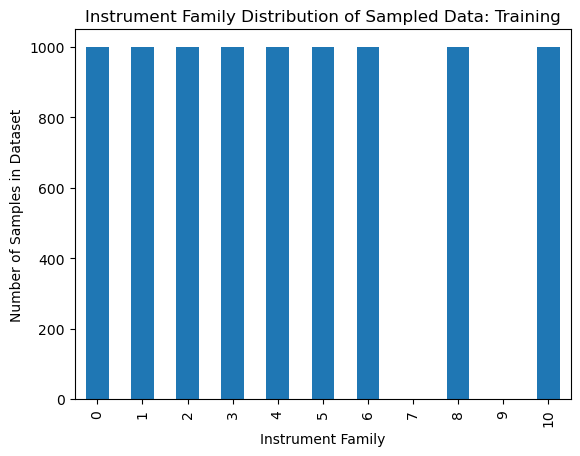

In [11]:
#Display instrument distrution
df_train_sample3['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train3), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [12]:
#save the train file index as list
filenames_train3 = df_train_sample3.index.tolist()

In [13]:
#save the list to a pickle file
with open('DataWrangling/filenames_train_less.pickle', 'wb') as f:
    pickle.dump(filenames_train3, f)

In [19]:
#extract the filenames from the validation dataset
df_valid_raw3 = pd.read_json(path_or_buf='nsynth-valid/examples.json', orient='index')

#Sample n files
df_valid3=df_valid_raw3.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(240)) #number of samples
#drop the synth_lead from the training dataset
df_valid3= df_valid3[df_valid3['instrument_family']!=9]

df_valid3 = df_valid3[df_valid3["instrument_family_str"] != 'reed']
print(df_valid3["instrument_family_str"].unique())
df_valid3.head()

['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'string'
 'vocal']


,note_str,sample_rate,qualities_str,instrument_source,instrument_family_str,instrument_family,note,instrument_source_str,qualities,pitch,instrument_str,instrument,velocity
bass_synthetic_068-024-075,bass_synthetic_068-024-075,16000,[dark],2,bass,0,259791,synthetic,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",24,bass_synthetic_068,656,75
bass_electronic_025-046-100,bass_electronic_025-046-100,16000,[],1,bass,0,252381,electronic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",46,bass_electronic_025,872,100
bass_synthetic_068-076-100,bass_synthetic_068-076-100,16000,[],2,bass,0,214459,synthetic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",76,bass_synthetic_068,656,100
bass_synthetic_135-087-025,bass_synthetic_135-087-025,16000,[distortion],2,bass,0,152675,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",87,bass_synthetic_135,927,25
bass_synthetic_098-053-100,bass_synthetic_098-053-100,16000,[distortion],2,bass,0,137622,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",53,bass_synthetic_098,803,100


In [20]:
#save the train file index as list
filenames_valid3 = df_valid3.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid_less.pickle', 'wb') as f:
    pickle.dump(filenames_valid3, f)

In [21]:
df_valid3.shape

(2160, 13)

In [22]:
#extract the filenames from the testing dataset

df_test_raw3 = pd.read_json(path_or_buf='nsynth-test/examples.json', orient='index')

#Sample n files
df_test3=df_test_raw3.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(80)) #number of samples
#drop the synth_lead from the training dataset
df_test3= df_test3[df_test3['instrument_family']!=9]

df_test3 = df_test3[df_test3["instrument_family_str"] != 'reed']
print(df_test3["instrument_family_str"].unique())
df_test3.head()

['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'string'
 'vocal']


,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
bass_synthetic_134-100-025,"[0, 0, 0, 1, 0, 0, 0, 1, 1, 0]",100,249735,synthetic,25,bass_synthetic_134,914,16000,"[fast_decay, percussive, reverb]",2,bass_synthetic_134-100-025,0,bass
bass_electronic_027-032-075,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",32,152068,electronic,75,bass_electronic_027,880,16000,[],1,bass_electronic_027-032-075,0,bass
bass_electronic_018-024-025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",24,233718,electronic,25,bass_electronic_018,759,16000,[],1,bass_electronic_018-024-025,0,bass
bass_synthetic_134-037-075,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",37,261239,synthetic,75,bass_synthetic_134,914,16000,"[dark, reverb]",2,bass_synthetic_134-037-075,0,bass
bass_synthetic_098-046-075,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",46,236901,synthetic,75,bass_synthetic_098,803,16000,[],2,bass_synthetic_098-046-075,0,bass


In [23]:
df_test3.shape

(720, 13)

In [24]:
#save the train file index as list
filenames_test3 = df_test3.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test_less.pickle', 'wb') as f:
    pickle.dump(filenames_test3, f)

In [25]:
def feature_extract3(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=138,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [26]:
def instrument_code3(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard','organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

In [27]:
#create dictionary to store all test features
dict_test3 = {}
#loop over every file in the list
for file3 in filenames_test3:
    #extract the features
    features3 = feature_extract3(test_dir3+ file3 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test3[file3] = features3

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [28]:
#convert dict to dataframe
features_test3 = pd.DataFrame.from_dict(dict_test3, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test3.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_134-100-025,0,"[-517.3466, 13.708894, 10.092674, 8.955691, 6....","[24.163532, 27.588339, 11.6852, 7.98326, 12.73...","[0.37857577, 0.40939462, 0.38416326, 0.3563198...","[13.586054101459506, 14.49437926087713, 13.602..."
bass_electronic_027-032-075,0,"[-451.73428, 61.492455, 55.462303, 51.68619, 4...","[1.9454391, 240.97746, 162.76227, 258.4619, 80...","[0.0, 0.009974638, 0.009948652, 0.042230364, 0...","[28.259190923630513, 23.564486355649585, 21.93..."
bass_electronic_018-024-025,0,"[-521.02826, 68.05501, 59.09461, 53.013004, 47...","[45.94687, 73.75425, 311.43527, 148.29117, 129...","[0.7285336, 0.15657471, 0.06377406, 0.01507554...","[26.07222012336698, 20.407633599069566, 14.864..."
bass_synthetic_134-037-075,0,"[-495.53964, 60.034615, 51.472553, 40.982937, ...","[7.563234, 9.751755, 23.602095, 8.554831, 13.7...","[0.15036952, 0.7840161, 0.17404415, 0.10447525...","[29.297011651062906, 30.447146264059054, 22.71..."
bass_synthetic_098-046-075,0,"[-459.24396, 31.295605, 23.04822, 19.93998, 19...","[76.35161, 1.1976035, 0.92913485, 15.518035, 4...","[0.282325, 0.35952544, 0.3493853, 0.34919992, ...","[36.35192401252157, 19.136824859440384, 14.750..."


In [29]:
#extract mfccs
mfcc_test3 = pd.DataFrame(features_test3.mfcc.values.tolist(),index=features_test3.index)
mfcc_test3 = mfcc_test3.add_prefix('mfcc_')

#extract spectro
spectro_test3 = pd.DataFrame(features_test3.spectro.values.tolist(),index=features_test3.index)
spectro_test3 = spectro_test3.add_prefix('spectro_')


#extract chroma
chroma_test3 = pd.DataFrame(features_test3.chroma.values.tolist(),index=features_test3.index)
chroma_test3 = chroma_test3.add_prefix('chroma_')


#extract contrast
contrast_test3 = pd.DataFrame(features_test3.contrast.values.tolist(),index=features_test3.index)
contrast_test3 = chroma_test3.add_prefix('contrast_')

#drop the old columns
features_test3 = features_test3.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test3=pd.concat([features_test3, mfcc_test3, spectro_test3, chroma_test3, contrast_test3],
                           axis=1, join='inner')
df_features_test3.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_134-100-025,0,-517.346619,13.708894,10.092674,8.955691,6.571458,4.144460,3.624881,3.732304,1.712268,...,0.384163,0.356320,0.342466,0.248693,0.185005,0.192230,0.203814,0.174023,0.083343,0.067454
bass_electronic_027-032-075,0,-451.734283,61.492455,55.462303,51.686192,45.300140,37.905334,31.920256,25.907938,20.389040,...,0.009949,0.042230,0.022178,0.029148,0.074330,0.180533,0.841785,0.180857,0.050145,0.013716
bass_electronic_018-024-025,0,-521.028259,68.055008,59.094608,53.013004,47.434303,40.914829,35.002842,29.312483,23.804100,...,0.063774,0.015076,0.047215,0.000000,0.005453,0.456481,0.009615,0.016131,0.033419,0.149838
bass_synthetic_134-037-075,0,-495.539642,60.034615,51.472553,40.982937,31.151451,22.924427,16.272430,10.921389,6.495123,...,0.174044,0.104475,0.060713,0.093630,0.063012,0.067319,0.363459,0.076271,0.051961,0.031031
bass_synthetic_098-046-075,0,-459.243958,31.295605,23.048220,19.939980,19.143194,17.669800,16.442875,15.474045,14.461076,...,0.349385,0.349200,0.247537,0.161175,0.072438,0.129550,0.096244,0.250677,0.417417,0.048640


In [30]:
targets_test3 = []
for name3 in df_features_test3.index.tolist():
    targets_test3.append(instrument_code3(name3))

df_features_test3['targets'] = targets_test3

In [31]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test_less.pickle', 'wb') as f:
    pickle.dump(df_features_test3, f)

In [32]:
df_features_test3.shape

(720, 177)

## Traning Set

In [40]:
start_train3 = time.time()

#create dictionary to store all test features
dict_train3 = {}
#loop over every file in the list
for file3 in filenames_train3:
    #extract the features
    features3 = feature_extract3(train_dir3 + file3 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_train3[file3] = features3

end_train3 = time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train3), end_train3 - start_train3))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 9000 files is 4685.8076367378235 seconds


In [41]:
#convert dict to dataframe
features_train3 = pd.DataFrame.from_dict(dict_train3, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train3.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_141-029-127,0,"[-319.76788, 175.19333, 40.833206, -10.359297,...","[371.01566, 3392.0332, 368.42853, 8.703237, 4....","[0.20199418, 0.030876894, 0.045541015, 0.09706...","[24.038164468771484, 19.133670534607944, 18.10..."
bass_synthetic_014-039-025,0,"[-471.93796, 26.3635, 7.6033626, 20.378784, 6....","[5.382206, 18.3131, 59.650826, 83.79669, 2.502...","[0.090020426, 0.15410857, 0.31830168, 0.409442...","[16.767557941916174, 18.436441246393485, 20.36..."
bass_synthetic_006-059-025,0,"[-396.16556, 4.633788, -40.776646, 31.319176, ...","[0.0073923618, 0.0031044842, 0.0037162239, 0.0...","[0.123724215, 0.117971115, 0.09919229, 0.44056...","[21.156110398217475, 28.372607832107793, 42.95..."
bass_synthetic_123-085-050,0,"[-523.8128, 3.2207162, -0.9534149, -0.27755415...","[0.8229296, 1.2519836, 1.2168101, 1.0246668, 0...","[0.20745564, 0.21034056, 0.16935876, 0.166108,...","[13.025859445820533, 12.854195207862052, 13.04..."
bass_synthetic_021-037-127,1,"[-480.12988, 45.19306, 35.885624, 31.641497, 2...","[1.320347, 15.857942, 301.32574, 86.103096, 0....","[0.3715358, 0.8083322, 0.09570922, 0.040233064...","[28.770537181874527, 24.572145737073228, 18.72..."


In [42]:
#extract mfccs
mfcc_train3 = pd.DataFrame(features_train3.mfcc.values.tolist(),
                          index=features_train3.index)
mfcc_train3 = mfcc_train3.add_prefix('mfcc_')

#extract spectro
spectro_train3 = pd.DataFrame(features_train3.spectro.values.tolist(),
                             index=features_train3.index)
spectro_train3 = spectro_train3.add_prefix('spectro_')


#extract chroma
chroma_train3 = pd.DataFrame(features_train3.chroma.values.tolist(),
                            index=features_train3.index)
chroma_train3 = chroma_train3.add_prefix('chroma_')


#extract contrast
contrast_train3 = pd.DataFrame(features_train3.contrast.values.tolist(),
                              index=features_train3.index)
contrast_train3 = chroma_train3.add_prefix('contrast_')

#drop the old columns
features_train3 = features_train3.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train3=pd.concat([features_train3, mfcc_train3, spectro_train3, chroma_train3, contrast_train3],
                           axis=1, join='inner')
df_features_train3.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_141-029-127,0,-319.767883,175.193329,40.833206,-10.359297,14.855524,29.182106,13.627123,3.084326,5.227895,...,0.045541,0.097064,0.209291,0.838198,0.147599,0.034005,0.000000,0.000000,0.000000,0.000000
bass_synthetic_014-039-025,0,-471.937958,26.363501,7.603363,20.378784,6.733419,9.378804,2.576012,4.050887,-0.057741,...,0.318302,0.409443,0.222885,0.074662,0.104696,0.136472,0.063833,0.164036,0.162534,0.041401
bass_synthetic_006-059-025,0,-396.165558,4.633788,-40.776646,31.319176,-17.912363,-5.913990,-22.681419,6.347715,-22.457975,...,0.099192,0.440568,0.060193,0.041912,0.378121,0.029842,0.011735,0.018822,0.016354,0.599892
bass_synthetic_123-085-050,0,-523.812805,3.220716,-0.953415,-0.277554,-0.984078,0.864527,1.162921,0.802848,-0.486203,...,0.169359,0.166108,0.155849,0.118775,0.107190,0.127987,0.131375,0.182440,0.129819,0.141098
bass_synthetic_021-037-127,1,-480.129883,45.193062,35.885624,31.641497,26.677032,22.510511,18.470043,15.656713,13.056710,...,0.095709,0.040233,0.016616,0.017030,0.012453,0.009689,0.032490,0.029849,0.034381,0.114080


In [43]:
targets_train3 = []
for name3 in df_features_train3.index.tolist():
    targets_train3.append(instrument_code3(name3))

In [44]:
df_features_train3['targets'] = targets_train3

In [45]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_train_less.pickle', 'wb') as f:
    pickle.dump(df_features_train3, f)

In [46]:
df_features_train3.shape

(9000, 177)

## Validation Set

In [33]:
start_valid3 = time.time()

#create dictionary to store all test features
dict_valid3 = {}
#loop over every file in the list
for file3 in filenames_valid3:
    #extract the features
    features3 = feature_extract3(valid_dir3+ file3 + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_valid3[file3] = features3

end_valid3=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid3), end_valid3 - start_valid3))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 2160 files is 1094.8828058242798 seconds


In [34]:
#convert dict to dataframe
features_valid3 = pd.DataFrame.from_dict(dict_valid3, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid3.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_068-024-075,0,"[-532.9141, 50.062958, 45.359436, 39.318256, 3...","[22.702778, 39.318443, 143.13312, 32.356213, 1...","[0.849464, 0.19840527, 0.07281354, 0.003013797...","[26.723351803785448, 24.56089511209622, 17.449..."
bass_electronic_025-046-100,1,"[-501.92523, 48.624165, 37.849537, 32.34552, 2...","[0.004855982, 0.06391363, 0.6711421, 5.4256825...","[0.05802931, 0.040779345, 0.026991842, 0.03090...","[32.015632202519114, 28.75821618890482, 22.647..."
bass_synthetic_068-076-100,1,"[-503.39526, 12.890608, 1.4891791, -3.5561595,...","[0.0030890813, 0.0047601233, 0.0053810976, 0.0...","[0.13113853, 0.11659437, 0.06341804, 0.0380746...","[12.501286504909162, 11.69793223923211, 36.579..."
bass_synthetic_135-087-025,0,"[-483.6314, 6.608603, -17.275537, -16.282093, ...","[0.006485854, 0.0049853767, 0.004296028, 0.003...","[0.020621635, 0.013188657, 0.021338318, 0.9877...","[17.704395720613615, 10.133438271790945, 12.64..."
bass_synthetic_098-053-100,0,"[-459.22052, 32.032425, 20.03052, 19.662582, 1...","[59.419144, 0.98444396, 0.4424237, 0.29458672,...","[0.38606384, 0.44005567, 0.3745304, 0.24965152...","[32.58775613194022, 19.778841531921692, 15.272..."


In [35]:
#extract mfccs
mfcc_valid3 = pd.DataFrame(features_valid3.mfcc.values.tolist(),
                          index=features_valid3.index)
mfcc_valid3 = mfcc_valid3.add_prefix('mfcc_')

#extract spectro
spectro_valid3 = pd.DataFrame(features_valid3.spectro.values.tolist(),
                             index=features_valid3.index)
spectro_valid3 = spectro_valid3.add_prefix('spectro_')


#extract chroma
chroma_valid3 = pd.DataFrame(features_valid3.chroma.values.tolist(),
                            index=features_valid3.index)
chroma_valid3 = chroma_valid3.add_prefix('chroma_')


#extract contrast
contrast_valid3 = pd.DataFrame(features_valid3.contrast.values.tolist(),
                              index=features_valid3.index)
contrast_valid3 = chroma_valid3.add_prefix('contrast_')

#drop the old columns
features_valid3 = features_valid3.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid3=pd.concat([features_valid3, mfcc_valid3, spectro_valid3, chroma_valid3, contrast_valid3],
                           axis=1, join='inner')
df_features_valid3.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_068-024-075,0,-532.914124,50.062958,45.359436,39.318256,33.428593,28.427792,24.334160,20.891104,17.909828,...,0.072814,0.003014,0.042396,0.001943,0.000937,0.268909,0.005331,0.002538,0.003723,0.092552
bass_electronic_025-046-100,1,-501.925232,48.624165,37.849537,32.345520,23.803242,17.301069,11.876151,5.775575,1.028170,...,0.026992,0.030907,0.025178,0.045455,0.042448,0.084090,0.106904,0.176058,0.859228,0.094106
bass_synthetic_068-076-100,1,-503.395264,12.890608,1.489179,-3.556159,-9.572459,-10.749473,-10.935246,-5.528647,2.539772,...,0.063418,0.038075,0.826861,0.090886,0.083091,0.058855,0.059344,0.038516,0.031592,0.066015
bass_synthetic_135-087-025,0,-483.631409,6.608603,-17.275537,-16.282093,-4.885576,17.379812,17.333843,-0.525953,-20.382170,...,0.021338,0.987730,0.007148,0.013189,0.015485,0.010410,0.010410,0.010410,0.014945,0.012134
bass_synthetic_098-053-100,0,-459.220520,32.032425,20.030519,19.662582,17.246159,15.976789,14.768022,13.568757,12.826461,...,0.374530,0.249652,0.267385,0.392355,0.211732,0.056107,0.026499,0.096529,0.025922,0.030988


In [37]:
targets_valid3 = []
for name3 in df_features_valid3.index.tolist():
    targets_valid3.append(instrument_code3(name3))

df_features_valid3['targets'] = targets_valid3

In [38]:
df_features_valid3.shape

(2160, 177)

In [39]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid_less.pickle_less', 'wb') as f:
    pickle.dump(df_features_valid3, f)

# Clean JSON Files

In [47]:
#extract qualities
train_qual3 = pd.DataFrame(df_train_sample3.qualities.values.tolist(), index= df_train_sample3.index)


#concatenate
json_train3=pd.concat([df_train_sample3, train_qual3],
                           axis=1, join='inner')

json_train3= json_train3.drop(labels=['qualities'], axis=1)
json_train3.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,...,0,1,2,3,4,5,6,7,8,9
bass_synthetic_141-029-127,223293,16000,29,2,bass,bass_synthetic_141,bass_synthetic_141-029-127,[distortion],synthetic,127,...,0,0,1,0,0,0,0,0,0,0
bass_synthetic_014-039-025,256547,16000,39,2,bass,bass_synthetic_014,bass_synthetic_014-039-025,"[bright, distortion, fast_decay]",synthetic,25,...,1,0,1,1,0,0,0,0,0,0
bass_synthetic_006-059-025,209452,16000,59,2,bass,bass_synthetic_006,bass_synthetic_006-059-025,"[bright, distortion, multiphonic]",synthetic,25,...,1,0,1,0,0,1,0,0,0,0
bass_synthetic_123-085-050,198411,16000,85,2,bass,bass_synthetic_123,bass_synthetic_123-085-050,"[fast_decay, percussive]",synthetic,50,...,0,0,0,1,0,0,0,1,0,0
bass_synthetic_021-037-127,15945,16000,37,2,bass,bass_synthetic_021,bass_synthetic_021-037-127,[],synthetic,127,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train_less.pickle', 'wb') as f:
    pickle.dump(json_train3, f)

In [49]:
#extract qualities
test_qual3 = pd.DataFrame(df_test3.qualities.values.tolist(), index= df_test3.index)


#concatenate
json_test3=pd.concat([df_test3, test_qual3],
                           axis=1, join='inner')

json_test3= json_test3.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test_less.pickle', 'wb') as f:
    pickle.dump(json_test3, f)

In [50]:
#extract qualities
valid_qual3 = pd.DataFrame(df_valid3.qualities.values.tolist(), index= df_valid3.index)


#concatenate
json_valid3=pd.concat([df_valid3, valid_qual3],
                           axis=1, join='inner')

json_valid3= json_valid3.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid_less.pickle', 'wb') as f:
    pickle.dump(json_valid3, f)